In [36]:
import numpy as np
import string
import os
import sys
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

sys.path.append('../')
from utils import acc_plot, loss_plot
tf.config.run_functions_eagerly(True)

## One hot encoding

In [2]:
samples = ["The cat sat on the mat.", "The dog ate my homework."]
token_index = {}

for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
max_length = 10 # we take only first 10 characters of each sample
results = np.zeros((len(samples), max_length, max(token_index.values())+1))


for i, sample in enumerate(samples):
    for j, word in enumerate(sample.split()):
        index = token_index.get(word)
        results[i, j, index-1] = 1

print(token_index)
results

{'The': 1, 'cat': 2, 'sat': 3, 'on': 4, 'the': 5, 'mat.': 6, 'dog': 7, 'ate': 8, 'my': 9, 'homework.': 10}


array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

In [3]:
# all characters
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters)+1)))
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values())+1))

for i, sample in enumerate(samples):
    for j, char in enumerate(sample):
        index = token_index.get(char)
        results[i, j, index] = 1

# with np.printoptions(threshold=np.inf):
#     print(results[0])
print(results)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [4]:
tokenizer = Tokenizer(num_words=100) # only 100 most common words

tokenizer.fit_on_texts(samples) # word index is build

sequences = tokenizer.texts_to_sequences(samples)

print(*sequences, '\n')

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index

print(one_hot_results[0, :10], "\n")

print(f'Tokens: {word_index}')

[1, 2, 3, 4, 1, 5] [1, 6, 7, 8, 9] 

[0. 1. 1. 1. 1. 1. 0. 0. 0. 0.] 

Tokens: {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}


#### One-hot hashing trick

In [5]:
dimensionality = 1000 # word represented as a vector of size 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
    for j, word in enumerate(sample.split()):
        index = abs(hash(word) % dimensionality) # 
        results[i, j, index] = 1
        
for i, el in enumerate(results[0][1]):
    if el > 0.5:
        print(i)

133


## Embeddings

In [6]:
max_features = 10000 # load 10000 most popular words from reviews
maxlen = 20 # cut review after 20 words

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

X_train = pad_sequences(X_train, maxlen=maxlen) # pad sequences to the same length
X_test = pad_sequences(X_test, maxlen=maxlen)

In [7]:
X_train.shape, X_test.shape

((25000, 20), (25000, 20))

In [8]:
X_train[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32], dtype=int32)

In [14]:
model = Sequential([
    Embedding(10000, 8, input_length=maxlen), # input_dim, output_dim (embedding vector length)
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_2 (Flatten)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.6573 - accuracy: 0.6353 - val_loss: 0.5766 - val_accuracy: 0.7148
Epoch 2/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4834 - accuracy: 0.7856 - val_loss: 0.4969 - val_accuracy: 0.7506
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3850 - accuracy: 0.8385 - val_loss: 0.4880 - val_accuracy: 0.7600
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3196 - accuracy: 0.8746 - val_loss: 0.4964 - val_accuracy: 0.7582
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.9031 - val_loss: 0.5184 - val_accuracy: 0.7506
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.2189 - accuracy: 0.9271 - val_loss: 0.5429 - val_accuracy: 0.7434
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.1792 - accuracy: 0.9461 - val_loss: 0.5756 - val_accuracy: 0.7398
Epoch 

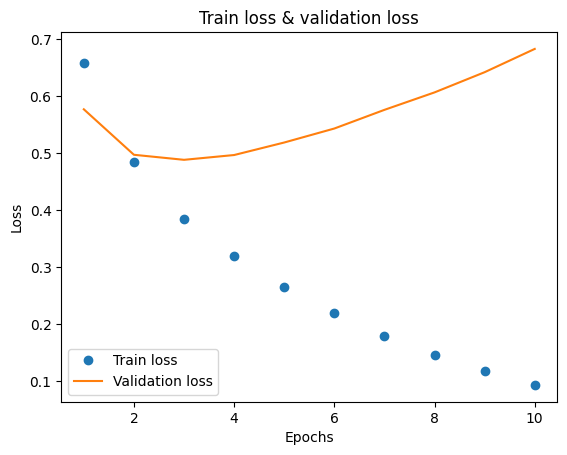

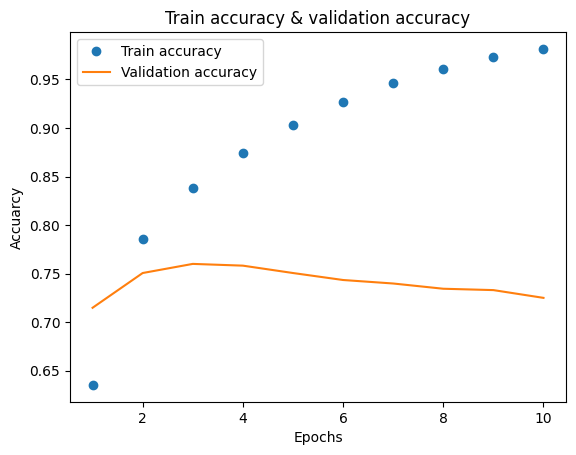

In [17]:
history_dict = history.history
loss_plot(history_dict, epochs=10)
acc_plot(history_dict, epochs=10)

## GloVe

In [2]:
# download raw data from: https://mng.bz/0tIo
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)    

In [3]:
len(texts)

25000

#### Tokenization

In [4]:
maxlen = 100 # cut review to only 100 words
train_samples = 200 # only 200 training samples !
val_samples = 10000
max_words = 10000 # 10000 most popular words from dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
f'Found {len(word_index)} unique tokens.' 

'Found 88582 unique tokens.'

In [5]:
data = pad_sequences(sequences, maxlen=maxlen) # shape (25k, 100)

labels = np.asarray(labels) # np.asarray(x) is a more flexible function than np.array(x), as it can avoid unnecessary memory allocation and copying if x is already a numpy array.

# Shuffling
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [30]:
X_train = data[:train_samples]
y_train = labels[:train_samples]
X_val = data[train_samples : train_samples + val_samples]
y_val = labels[train_samples : train_samples + val_samples]

#### Load GloVe word vectors

In [9]:
# Download GloVe word vectors from: http://nlp.stanford.edu/projects/glove (GloVe6B)
glove_dir = 'glove6B'
embeddings_index = dict()
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

f'Found {len(embeddings_index)} word vectors'

'Found 400000 word vectors'

In [19]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) # returns none if word is not found
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(10000, 100)

#### Defining model and training

In [22]:
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=maxlen),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history = model.fit(
    X_train,
    y_train, 
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
7/7 [==============================] - 1s 222ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.8327 - val_accuracy: 0.5549
Epoch 2/10
7/7 [==============================] - 1s 233ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.8480 - val_accuracy: 0.5597
Epoch 3/10
7/7 [==============================] - 1s 220ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.8583 - val_accuracy: 0.5593
Epoch 4/10
7/7 [==============================] - 1s 225ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8715 - val_accuracy: 0.5594
Epoch 5/10
7/7 [==============================] - 1s 231ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.8847 - val_accuracy: 0.5570
Epoch 6/10
7/7 [==============================] - 1s 236ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.8962 - val_accuracy: 0.5585
Epoch 7/10
7/7 [==============================] - 2s 256ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.9060 - val_accuracy: 0.5592
Epoch 8/10
7/7 [====

In [37]:
model.save_weights('pre_trained_glove.h5')

In [39]:
# history_dict = history.history
# loss_plot(history_dict, epochs=10)
# acc_plot(history_dict, epochs=10)

#### Same model without prepared word embeddings
Generally this solution should work better for big datasets - our is very small ;-(

In [40]:
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=maxlen),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train, 
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
7/7 [==============================] - 1s 230ms/step - loss: 0.6945 - accuracy: 0.4600 - val_loss: 0.6925 - val_accuracy: 0.5159
Epoch 2/10
7/7 [==============================] - 1s 207ms/step - loss: 0.5747 - accuracy: 0.9700 - val_loss: 0.6932 - val_accuracy: 0.5120
Epoch 3/10
7/7 [==============================] - 1s 210ms/step - loss: 0.4610 - accuracy: 0.9950 - val_loss: 0.6942 - val_accuracy: 0.5151
Epoch 4/10
7/7 [==============================] - 1s 229ms/step - loss: 0.3041 - accuracy: 0.9950 - val_loss: 0.7018 - val_accuracy: 0.5133
Epoch 5/10
7/7 [==============================] - 1s 209ms/step - loss: 0.1586 - accuracy: 1.0000 - val_loss: 0.7096 - val_accuracy: 0.5181
Epoch 6/10
7/7 [==============================] - 1s 205ms/step - loss: 0.0668 - accuracy: 1.0000 - val_loss: 0.7095 - val_accuracy: 0.5179
Epoch 7/10
7/7 [==============================] - 1s 213ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.7155 - val_accuracy: 0.5214
Epoch 8/10
7/7 [====

#### Evaluation

In [41]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1) 

sequences = tokenizer.texts_to_sequences(texts)
X_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [42]:
model.load_weights('pre_trained_glove.h5')
model.evaluate(X_test, y_test)

 38/782 [>.............................] - ETA: 3s - loss: 0.8920 - accuracy: 0.5617

/home/kamil/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


782/782 [==============================] - 3s 4ms/step - loss: 0.9236 - accuracy: 0.5574


[0.9236359596252441, 0.5573599934577942]

Well, working with small number of samples is hard.